<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

Previous notebook, we cover transfer learning feature extraction, now it's time to learn a new kind of transfer learning: fine-tuning.

In [117]:
# Check if we're using a GPU
!nvidia-smi

Sun Jan 22 20:18:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |   4978MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-22 13:02:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-22 13:02:31 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [118]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply to our own problem (recongnizing images of food).

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-22 13:12:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.7MB/s    in 8.1s    

2023-01-22 13:12:58 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [119]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [120]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[4.59132652e+01 1.69132652e+01 8.91326523e+00]
   [4.75969391e+01 2.05969391e+01 1.15969391e+01]
   [5.12091827e+01 2.42091827e+01 1.52091837e+01]
   ...
   [7.97959900e+01 3.59285698e+01 2.17856712e+01]
   [9.45714264e+01 4.49030457e+01 2.56173172e+01]
   [9.90766754e+01 4.47909622e+01 2.48623924e+01]]

  [[4.66887779e+01 1.73571434e+01 9.35714436e+00]
   [5.06377563e+01 2.25051041e+01 1.15714302e+01]
   [5.51428604e+01 2.67448978e+01 1.59438782e+01]
   ...
   [1.19688934e+02 6.62042160e+01 3.32755966e+01]
   [1.62617661e+02 1.06556396e+02 7.21125259e+01]
   [2.12276138e+02 1.52439392e+02 1.16913879e+02]]

  [[5.68571434e+01 2.38571434e+01 1.48571434e+01]
   [6.08010216e+01 2.78010216e+01 1.88010216e+01]
   [6.24030609e+01 2.96938763e+01 1.99744892e+01]
   ...
   [1.99407944e+02 1.40239624e+02 9.82396698e+01]
   [1.60841675e+02 1.03030472e+02 6.40151901e+01]
   [1.24703438e+02 7.12187653e+01 3.35044785e+01]]

  ...

  [[3.20101662e+01 1.87959023e+01 9.79590321e+00]
   [3

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [121]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patters aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=create_tensorboard_callback("tensorflow_hub", "efficientnetb0"))

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230122-201833
Epoch 1/5
24/24 [==============================] - 14s 367ms/step - loss: 1.8769 - accuracy: 0.4027 - val_loss: 1.3313 - val_accuracy: 0.7328
Epoch 2/5
24/24 [==============================] - 8s 308ms/step - loss: 1.0851 - accuracy: 0.7760 - val_loss: 0.8796 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 8s 308ms/step - loss: 0.7813 - accuracy: 0.8427 - val_loss: 0.6997 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 8s 310ms/step - loss: 0.6335 - accuracy: 0.8640 - val_loss: 0.6120 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 8s 310ms/step - loss: 0.5400 - accuracy: 0.8880 - val_loss: 0.5548 - val_accuracy: 0.8608


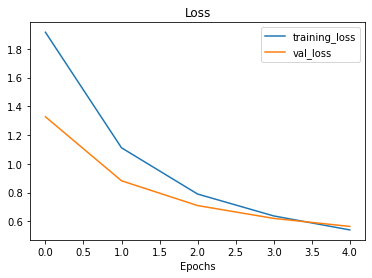

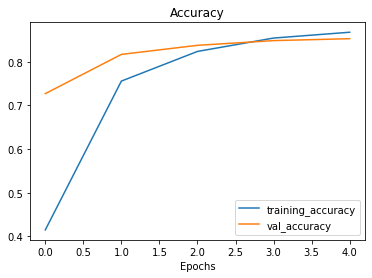

In [13]:
plot_loss_curves(history_0)

In [122]:
# Evaluate on full test data
model_0.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.5548 - accuracy: 0.8608


[0.5547837615013123, 0.86080002784729]

In [123]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_9
1 rescaling_8
2 normalization_8
3 tf.math.truediv_8
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [124]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


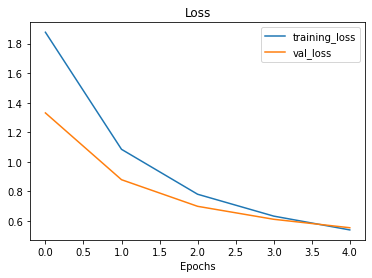

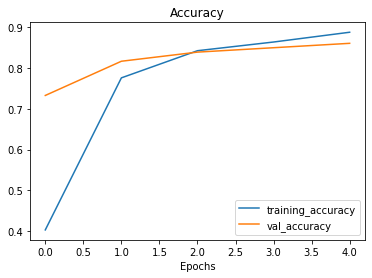

In [125]:
# Check put our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [126]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: {input_tensor}\n")

# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: [[[[ 1.3563817e+00 -3.5038263e-01 -2.7211538e-01]
   [ 4.2738435e-01  1.1580451e-01  4.7232255e-01]
   [-3.4535530e-01  2.2515798e-01 -1.9733642e+00]
   [-6.8430811e-01  1.1492976e+00 -5.2563709e-01]]

  [[-1.5732066e-01  1.0998891e-01 -7.0833397e-01]
   [-9.5251238e-01 -9.1197711e-01  5.8602858e-01]
   [-1.6450511e+00 -1.8978865e+00  2.7165711e-01]
   [ 7.0533350e-02  3.1615192e-01 -7.0196456e-01]]

  [[ 2.4444030e-01 -3.2046875e-01  5.6285268e-01]
   [-1.9178911e+00 -1.0532386e+00  5.2593929e-01]
   [-6.7328596e-01 -1.5513608e-01 -1.6285046e-03]
   [-9.3639892e-01 -1.3181568e+00 -1.0885683e+00]]

  [[ 1.4054015e-01  2.2532493e-01  1.1813617e+00]
   [-9.9117702e-01 -2.1029177e-01  7.0448083e-01]
   [-7.7062428e-01  3.8444278e-01 -7.0804828e-01]
   [ 3.5423625e-02 -5.4282999e-01 -4.5851231e-01]]]]

2D Global average pooled random tensor:
 [[-0.42495134 -0.26463747 -0.13334565]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [127]:
# Let's replicate the Global Average Pooled 2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.42495134, -0.26463747, -0.13334565]], dtype=float32)>

> ⚒️ **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about set  up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10%  of training data with augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset wil be used to evaluate our mode... this ensures consistency across evaluation metrics.



## Getting and preprocessing data for model_1

In [23]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-01-22 16:15:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  24.0MB/s    in 6.4s    

2023-01-22 16:15:17 (19.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [128]:
# Create train and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"



In [129]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [130]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32) # Default

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our heads, after  reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation onlu happens during training, so we can still export our whole model and use it elsewhere.

In [135]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
#    preprocessing.Rescale(1.255) # Keep for models like ResNet50V2 but EfficientNet already preprocessed
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

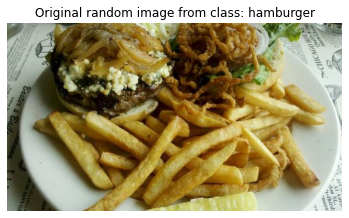

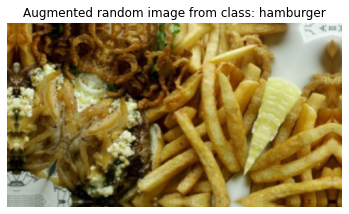

In [132]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_img = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_img

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature Eetraction transfer learning on 1% of the data with data augmentation

In [136]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=True)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=create_tensorboard_callback("tensorflow_hub", "1_percent_data_augmented"))

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_augmented/20230122-202104
Epoch 1/5
3/3 [==============================] - 12s 3s/step - loss: 2.4188 - accuracy: 0.0571 - val_loss: 2.3145 - val_accuracy: 0.1118
Epoch 2/5
3/3 [==============================] - 6s 3s/step - loss: 2.1623 - accuracy: 0.2429 - val_loss: 2.1823 - val_accuracy: 0.1957
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9310 - accuracy: 0.4000 - val_loss: 2.0955 - val_accuracy: 0.2516
Epoch 4/5
3/3 [==============================] - 3s 2s/step - loss: 1.7745 - accuracy: 0.5429 - val_loss: 1.9824 - val_accuracy: 0.3553
Epoch 5/5
3/3 [==============================] - 6s 3s/step - loss: 1.6125 - accuracy: 0.6571 - val_loss: 1.9169 - val_accuracy: 0.3832


In [137]:
# Check out a model summary
model_1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [138]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 12s 148ms/step - loss: 1.8992 - accuracy: 0.3956


[1.899180293083191, 0.39559999108314514]

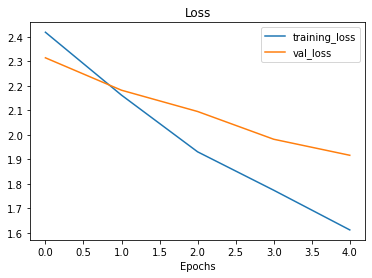

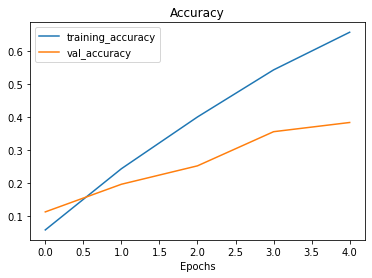

In [139]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation


In [140]:
# Get 10% of training data of 10 classes of food101 (uncomment if you don't have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [141]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [142]:
# Create model_2 with data augmentation build in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
  #  preprocessing.Rescaling(1./255)
], name="data_augmentation")

In [143]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



### Creating a ModelCheckpoint callback

The ModeCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where left off.

In [144]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weight/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

### Fot model 2 passing in the ModelCheckpoint callback

In [145]:
# Fot the model saving checkpoints every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("tensorflow_hub", "10_percent_data_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20230122-202259
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9584 - accuracy: 0.3707
Epoch 1: val_loss improved from inf to 1.39387, saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 15s 425ms/step - loss: 1.9584 - accuracy: 0.3707 - val_loss: 1.3939 - val_accuracy: 0.6960
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2846 - accuracy: 0.7027
Epoch 2: val_loss improved from 1.39387 to 0.96348, saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 9s 385ms/step - loss: 1.2846 - accuracy: 0.7027 - val_loss: 0.9635 - val_accuracy: 0.7964
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9827 - accuracy: 0.7653
Epoch 3: val_loss improved from 0.96348 to 0.77971, saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [========

In [146]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.5548 - accuracy: 0.8608


[0.5547837615013123, 0.86080002784729]

In [147]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 69ms/step - loss: 0.6199 - accuracy: 0.8328


[0.619899332523346, 0.8327999711036682]

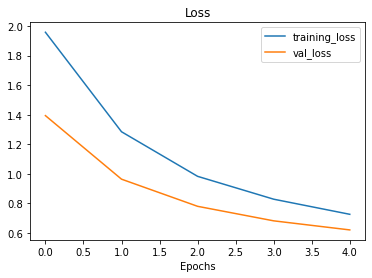

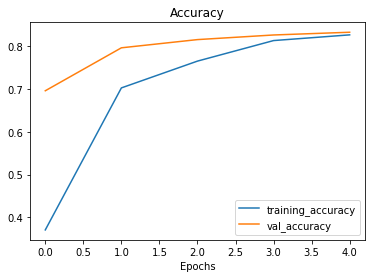

In [148]:
plot_loss_curves(history_2)

###  Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [149]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [150]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6199 - accuracy: 0.8328


In [151]:
# If the results from our previously evaluated model_2 match the loaded weights, everything works/
results_10_percent_data_aug == loaded_weights_model_results

False

In [152]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [153]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [154]:
# Layers in loaded model
model_2.layers

In [155]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa4e41c4d90> True
<keras.engine.sequential.Sequential object at 0x7fa3f9e75ac0> True
<keras.engine.functional.Functional object at 0x7fa3fbab97f0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa4e3074430> True
<keras.layers.core.dense.Dense object at 0x7fa3fba52d60> True


In [156]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_13 False
1 rescaling_12 False
2 normalization_12 False
3 tf.math.truediv_12 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_sq

In [157]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [158]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss=tf.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])

>🔑 **Note:** When using fine-tuning it's best practice to lower  your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the ULMFit paper

In [159]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_13 False
1 rescaling_12 False
2 normalization_12 False
3 tf.math.truediv_12 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_sq

In [160]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables?
print(len(model_2.trainable_variables))

12


In [161]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_2_tuned = model_2.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=history_2.epoch[-1], # start training from previous last epoch
                              callbacks=[create_tensorboard_callback("tensorflow_hub", "10_percent_fine_tuned_last_10")])

Saving TensorBoard log files to: tensorflow_hub/10_percent_fine_tuned_last_10/20230122-202432
Epoch 5/10
24/24 [==============================] - 12s 287ms/step - loss: 0.6281 - accuracy: 0.8133 - val_loss: 0.5060 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - 6s 231ms/step - loss: 0.5095 - accuracy: 0.8413 - val_loss: 0.4726 - val_accuracy: 0.8470
Epoch 7/10
24/24 [==============================] - 6s 241ms/step - loss: 0.4680 - accuracy: 0.8560 - val_loss: 0.4516 - val_accuracy: 0.8503
Epoch 8/10
24/24 [==============================] - 6s 225ms/step - loss: 0.3770 - accuracy: 0.8867 - val_loss: 0.4328 - val_accuracy: 0.8618
Epoch 9/10
24/24 [==============================] - 9s 337ms/step - loss: 0.3668 - accuracy: 0.8973 - val_loss: 0.4428 - val_accuracy: 0.8536
Epoch 10/10
24/24 [==============================] - 6s 233ms/step - loss: 0.3470 - accuracy: 0.8867 - val_loss: 0.4681 - val_accuracy: 0.8454


In [162]:
# Evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4313 - accuracy: 0.8544


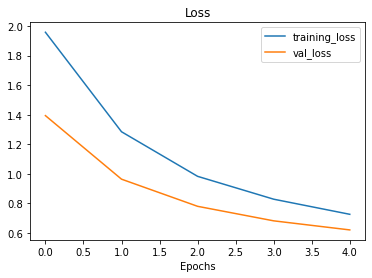

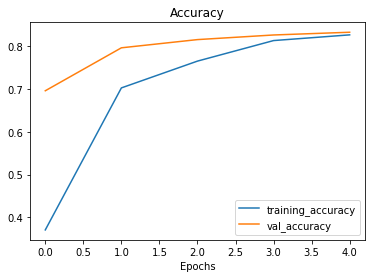

In [163]:
plot_loss_curves(history_2)

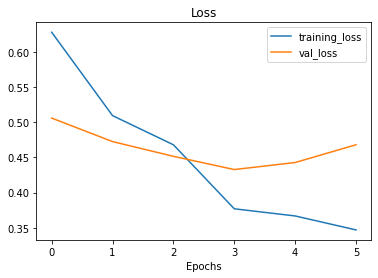

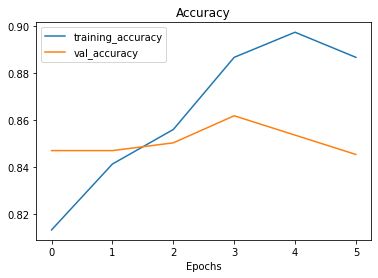

In [164]:
plot_loss_curves(history_2_tuned)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [165]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Loss")

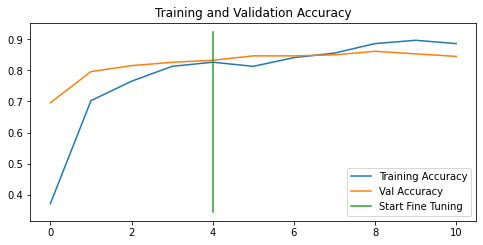

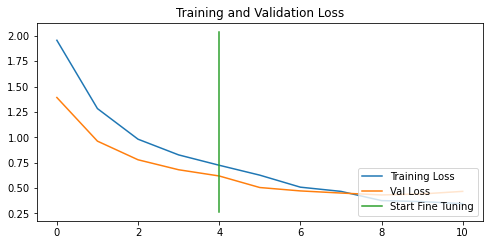

In [166]:
compare_historys(history_2, history_2_tuned, 5)

## Model 4: Fine-tuning an existing model on all of the data

In [167]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-01-22 20:25:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 172.217.194.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  24.3MB/s    in 22s     

2023-01-22 20:25:58 (22.5 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [168]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [169]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [170]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [171]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4313 - accuracy: 0.8544


[0.4312748610973358, 0.8543999791145325]

In [172]:
results_fine_tune_10_percent

[0.4312748908996582, 0.8543999791145325]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.


In [173]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from 
model_2.load_weights(checkpoint_path)

In [174]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.6199 - accuracy: 0.8328


[0.619899332523346, 0.8327999711036682]

In [175]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.619899332523346, 0.8327999711036682]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's wights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data(model_4

In [176]:
# Check wich layers are tunable in the whole model
for layer_numer, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

237 input_layer True
237 data_augmentation True
237 efficientnetb0 True
237 global_average_pooling_2D True
237 output_layer True


In [177]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_13 False
1 rescaling_12 False
2 normalization_12 False
3 tf.math.truediv_12 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_sq

In [178]:
# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [179]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

# Fit the model
history_full_data = model_2.fit(train_data_10_classes_full,
                                epochs=fine_tune_epochs,
                                validation_data=test_data,
                                validation_steps=(0.25 * len(test_data)),
                                initial_epoch=history_2.epoch[-1],
                                callbacks=[create_tensorboard_callback("tensorflow_hub", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: tensorflow_hub/full_10_classes_fine_tune_last_10/20230122-202628
Epoch 5/10
235/235 [==============================] - 42s 155ms/step - loss: 0.6149 - accuracy: 0.8068 - val_loss: 0.3451 - val_accuracy: 0.8781
Epoch 6/10
235/235 [==============================] - 29s 121ms/step - loss: 0.4318 - accuracy: 0.8599 - val_loss: 0.2857 - val_accuracy: 0.8953
Epoch 7/10
235/235 [==============================] - 30s 125ms/step - loss: 0.3350 - accuracy: 0.8919 - val_loss: 0.3005 - val_accuracy: 0.9016
Epoch 8/10
235/235 [==============================] - 30s 123ms/step - loss: 0.2797 - accuracy: 0.9048 - val_loss: 0.2983 - val_accuracy: 0.9000
Epoch 9/10
235/235 [==============================] - 28s 116ms/step - loss: 0.2430 - accuracy: 0.9191 - val_loss: 0.3386 - val_accuracy: 0.8781
Epoch 10/10
235/235 [==============================] - 28s 117ms/step - loss: 0.1939 - accuracy: 0.9340 - val_loss: 0.2970 - val_accuracy: 0.8922


In [180]:
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.3018 - accuracy: 0.9004


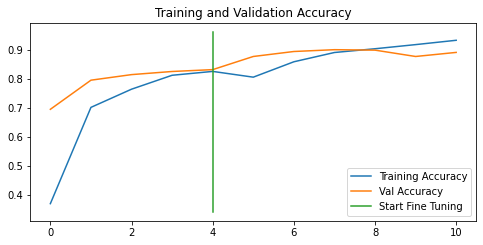

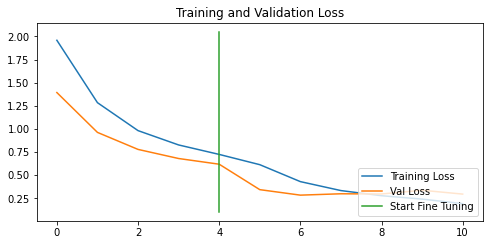

In [181]:
# How did fine-tuning go with more data?
compare_historys(history_2, history_full_data, 5)

## Viewing our experiment data on TensorBoard

>🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [186]:
# View tensorboard logs fof transfer learning modelling experiments
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub \
#   --name "Transfer Learning Experiments with 10 Food101 Classes" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
#   --one_shot

In [187]:
# !tensorboard dev list


TensorBoard: https://tensorboard.dev/experiment/ZGrFOBX0TxWGLBLim3wxyw/#scalars